## built a two-stage pipeline:

## 1. Segmentation with U-Net → localize tumors on BUSI ultrasound images.

## 2. Classification with ResNet50 → classify segmented tumor patches into Normal, Benign, Malignan

## Install any missing packages

In [2]:
!nvidia-smi

Thu Aug 21 06:47:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install segmentation-models-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.0 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.3 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 13.1 MB/s eta 0:00:00:00:0100:01
  Attempting un

## Import libraries:

In [4]:
import os
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models


# Step 1: Load BUSI Dataset

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryashah2k/breast-ultrasound-images-dataset")

print("Path to dataset files:", path)

#Check dataset 

import os

DATA_PATH = "/kaggle/input/breast-ultrasound-images-dataset"  # adjust if needed

# Check files
for root, dirs, files in os.walk(DATA_PATH):
    if files:
        print(root, "->", len(files), "files")

Path to dataset files: /kaggle/input/breast-ultrasound-images-dataset
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign -> 891 files
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal -> 266 files
/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant -> 421 files


##  1: Collect Images and Masks

In [6]:
import os
from glob import glob

DATA_PATH = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/"

# Find all images and masks
all_files = glob(os.path.join(DATA_PATH, "**/*.png"), recursive=True)

# Separate images and masks
images = [f for f in all_files if "mask" not in f.lower()]
masks = [f for f in all_files if "mask" in f.lower() or "gt" in f.lower()]

print(f"Total images: {len(images)}")
print(f"Total masks: {len(masks)}")


Total images: 780
Total masks: 1578


## Match Images to Masks

In [7]:
# Map each image to its mask based on filename
image_to_mask = {}
for img_path in images:
    base = os.path.basename(img_path).split('.')[0]
    mask_match = [m for m in masks if base in os.path.basename(m)]
    if mask_match:
        image_to_mask[img_path] = mask_match[0]
    else:
        image_to_mask[img_path] = None  # fallback if mask missing

print(f"Images with masks: {sum([m is not None for m in image_to_mask.values()])}")


Images with masks: 780


## Train/val split

In [8]:
from sklearn.model_selection import train_test_split

# Keep only images with masks for segmentation
segmentation_imgs = [img for img, m in image_to_mask.items() if m is not None]
segmentation_masks = [image_to_mask[img] for img in segmentation_imgs]

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    segmentation_imgs, segmentation_masks, test_size=0.2, random_state=42
)

print("Train images:", len(train_imgs), "Validation images:", len(val_imgs))


Train images: 624 Validation images: 156


## U-Net Dataset Class

In [9]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np

class UltrasoundDataset(Dataset):
    def __init__(self, images, masks, img_size=(256, 256), transform=None):
        self.images = images
        self.masks = masks
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load grayscale
        img = cv2.imread(self.images[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)

        # Resize
        img = cv2.resize(img, self.img_size)
        mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)

        # Normalize
        img = img / 255.0
        mask = mask.astype(np.float32) / 255.0

        # Add channel dimension
        img = np.expand_dims(img, axis=0)
        mask = np.expand_dims(mask, axis=0)

        if self.transform:
            img = self.transform(img)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


## U-Net Model (PyTorch)

In [10]:
import torch.nn as nn
import torch

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = conv_block(256, 512)

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        # Final output
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))

        # Bottleneck
        b = self.bottleneck(self.pool3(e3))

        # Decoder path
        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        # Output: segmentation mask probability
        return torch.sigmoid(self.final(d1))


## Prepare DataLoaders

### Resize All Images and Masks Properly

In [11]:
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class UltrasoundDataset(Dataset):
    def __init__(self, images, masks, img_size=(256, 256)):
        self.images = images
        self.masks = masks
        self.img_size = img_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Read grayscale image
        img = cv2.imread(self.images[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.masks[idx], cv2.IMREAD_GRAYSCALE)

        # Resize both image and mask to fixed size
        img = cv2.resize(img, self.img_size)             # bilinear default
        mask = cv2.resize(mask, self.img_size, interpolation=cv2.INTER_NEAREST)

        # Normalize
        img = img / 255.0
        mask = mask / 255.0
        mask = mask.astype(np.float32)

        # Add channel dimension (C,H,W)
        img = np.expand_dims(img, axis=0)
        mask = np.expand_dims(mask, axis=0)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


In [12]:
from torch.utils.data import DataLoader

# Use the updated UltrasoundDataset with img_size parameter
train_dataset = UltrasoundDataset(train_imgs, train_masks, img_size=(256, 256))
val_dataset   = UltrasoundDataset(val_imgs, val_masks, img_size=(256, 256))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)


## Train U-Net

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):  # start with small epochs
    model.train()
    train_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.5275
Epoch 2, Loss: 0.4805
Epoch 3, Loss: 0.4797
Epoch 4, Loss: 0.4755
Epoch 5, Loss: 0.4740
Epoch 6, Loss: 0.4732
Epoch 7, Loss: 0.4715
Epoch 8, Loss: 0.4708
Epoch 9, Loss: 0.4701
Epoch 10, Loss: 0.4723


# Step 2: ResNet50 classification

### Import Libraries & Setup

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


## 2: Prepare Tumor Dataset

##   Prepare Dataset for ResNet50
### 1. Convert grayscale to 3 channels because ResNet50 expects 3-channel input.

### 2. Resize to 224×224 for ResNet50.

In [18]:
from torch.utils.data import Dataset, DataLoader
import cv2
import os
from sklearn.model_selection import train_test_split
from torchvision import transforms

# 1️⃣ Define Dataset
class TumorDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # ensure 3 channels
        img = cv2.resize(img, (224,224))

        if self.transform:
            img = self.transform(img)

        # Extra check: if somehow 1 channel remains, repeat it
        if img.shape[0] == 1:  # [C,H,W]
            img = img.repeat(3,1,1)

        label = self.labels[idx]
        return img, label

# 2️⃣ Collect image paths & labels
base_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"
classes = ["benign", "malignant", "normal"]
img_paths, labels = [], []

for i, cls in enumerate(classes):
    cls_folder = os.path.join(base_path, cls)
    for f in os.listdir(cls_folder):
        if f.endswith(".png") or f.endswith(".jpg"):
            img_paths.append(os.path.join(cls_folder, f))
            labels.append(i)  # 0=benign, 1=malignant, 2=normal

# 3️⃣ Train/Test Split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    img_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# 4️⃣ Transform for ResNet50
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# 5️⃣ DataLoaders
train_dataset = TumorDataset(train_paths, train_labels, transform=transform)
val_dataset   = TumorDataset(val_paths, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(f"✅ Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


✅ Train samples: 1262, Validation samples: 316


## 3 — Load Pretrained ResNet50

In [20]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT  # most up-to-date pretrained weights
model = resnet50(weights=weights)

# Replace the final layer for 3-class classification
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 3)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]


In [21]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------
# 2️⃣ Load Pretrained ResNet50
# ------------------------
num_classes = 3  # benign, malignant, normal
model = models.resnet50(pretrained=True)

# Replace the final fully connected layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

# ------------------------
# 3️⃣ Loss & Optimizer
# ------------------------
criterion = nn.CrossEntropyLoss()  # suitable for multi-class
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print(f"✅ ResNet50 ready for {num_classes}-class classification on device: {device}")

✅ ResNet50 ready for 3-class classification on device: cuda


In [22]:
from tqdm import tqdm

# ------------------------
# Training Setup
# ------------------------
num_epochs = 10
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # ------------------------
    # Training
    # ------------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # ------------------------
    # Validation
    # ------------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

            # Store labels & predictions for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)

    print(f"Epoch {epoch+1}: Train Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.4f} | "
          f"Val Loss={val_epoch_loss:.4f}, Val Acc={val_epoch_acc:.4f}")

    # ------------------------
    # Save Best Model
    # ------------------------
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model.state_dict(), "best_resnet50.pth")
        print("✅ Saved best model")

print(f"✅ Training complete. Best validation accuracy: {best_val_acc:.4f}")


Epoch 1/10: 100%|██████████| 79/79 [00:24<00:00,  3.28it/s]


Epoch 1: Train Loss=0.4394, Train Acc=0.8170 | Val Loss=0.3355, Val Acc=0.8924
✅ Saved best model


Epoch 2/10: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


Epoch 2: Train Loss=0.2394, Train Acc=0.9144 | Val Loss=0.2256, Val Acc=0.9177
✅ Saved best model


Epoch 3/10: 100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


Epoch 3: Train Loss=0.1328, Train Acc=0.9572 | Val Loss=0.3741, Val Acc=0.8892


Epoch 4/10: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


Epoch 4: Train Loss=0.1153, Train Acc=0.9604 | Val Loss=0.2339, Val Acc=0.9209
✅ Saved best model


Epoch 5/10: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


Epoch 5: Train Loss=0.1209, Train Acc=0.9612 | Val Loss=0.2132, Val Acc=0.9114


Epoch 6/10: 100%|██████████| 79/79 [00:20<00:00,  3.80it/s]


Epoch 6: Train Loss=0.0624, Train Acc=0.9810 | Val Loss=0.1659, Val Acc=0.9462
✅ Saved best model


Epoch 7/10: 100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


Epoch 7: Train Loss=0.0700, Train Acc=0.9754 | Val Loss=0.2956, Val Acc=0.8956


Epoch 8/10: 100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


Epoch 8: Train Loss=0.0474, Train Acc=0.9857 | Val Loss=0.1989, Val Acc=0.9304


Epoch 9/10: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]


Epoch 9: Train Loss=0.0478, Train Acc=0.9818 | Val Loss=0.2322, Val Acc=0.9304


Epoch 10/10: 100%|██████████| 79/79 [00:20<00:00,  3.78it/s]


Epoch 10: Train Loss=0.0278, Train Acc=0.9929 | Val Loss=0.1494, Val Acc=0.9430
✅ Training complete. Best validation accuracy: 0.9462


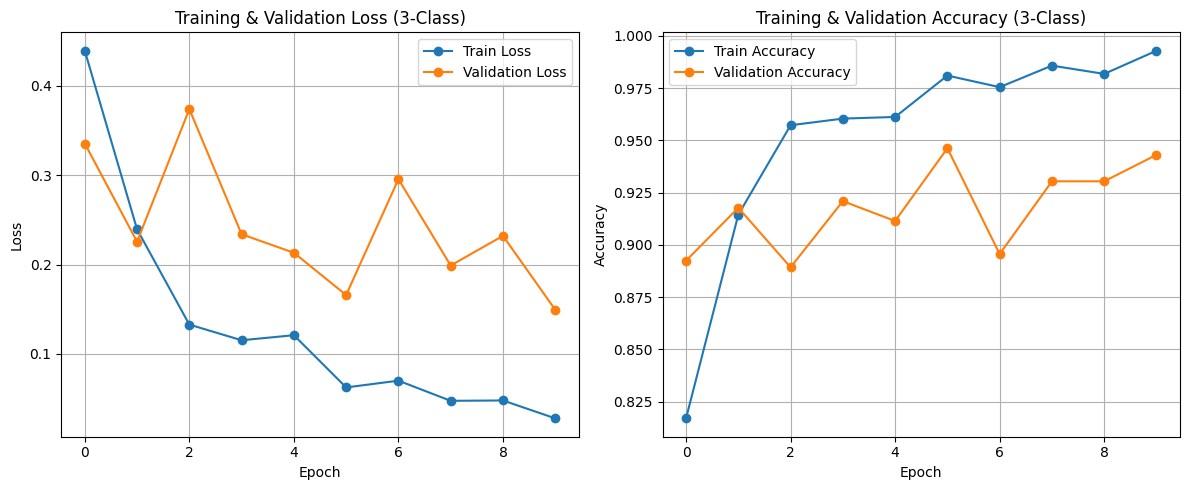

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))


# Loss Curve

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title("Training & Validation Loss (3-Class)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)


# Accuracy Curve

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Validation Accuracy', marker='o')
plt.title("Training & Validation Accuracy (3-Class)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 6 — Confusion Matrix

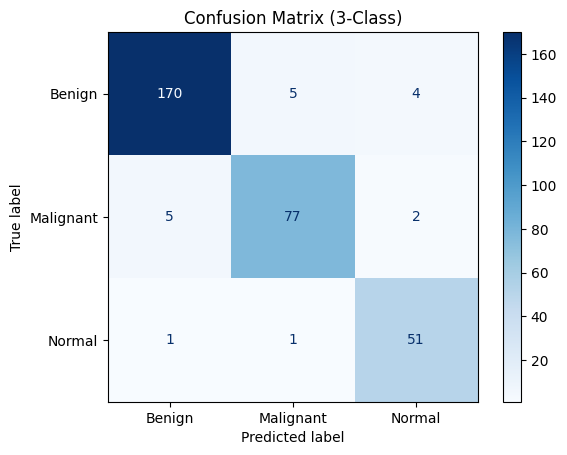

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------------
# Confusion Matrix
# ------------------------
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Benign", "Malignant", "Normal"])
disp.plot(cmap=plt.cm.Blues, values_format='d')  # integer values
plt.title("Confusion Matrix (3-Class)")
plt.show()


### Labels must match: 0 → Normal, 1 → Benign, 2 → Malignan

# 1. Segmentation Visualization

In [35]:
# import matplotlib.pyplot as plt

# def visualize_segmentation(img_path, mask_pred):
#     """
#     img_path: path to original image
#     mask_pred: predicted mask (numpy array, 256x256)
#     """
#     img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (256,256))
    
#     plt.figure(figsize=(8,4))
    
#     # Original image
#     plt.subplot(1,2,1)
#     plt.imshow(img, cmap='gray')
#     plt.title("Original Image")
#     plt.axis('off')
    
#     # Image + predicted mask overlay
#     plt.subplot(1,2,2)
#     plt.imshow(img, cmap='gray')
#     plt.imshow(mask_pred, cmap='Reds', alpha=0.5)  # mask overlay
#     plt.title("Segmentation Overlay")
#     plt.axis('off')
    
#     plt.show()


# 2. Classification Visualization

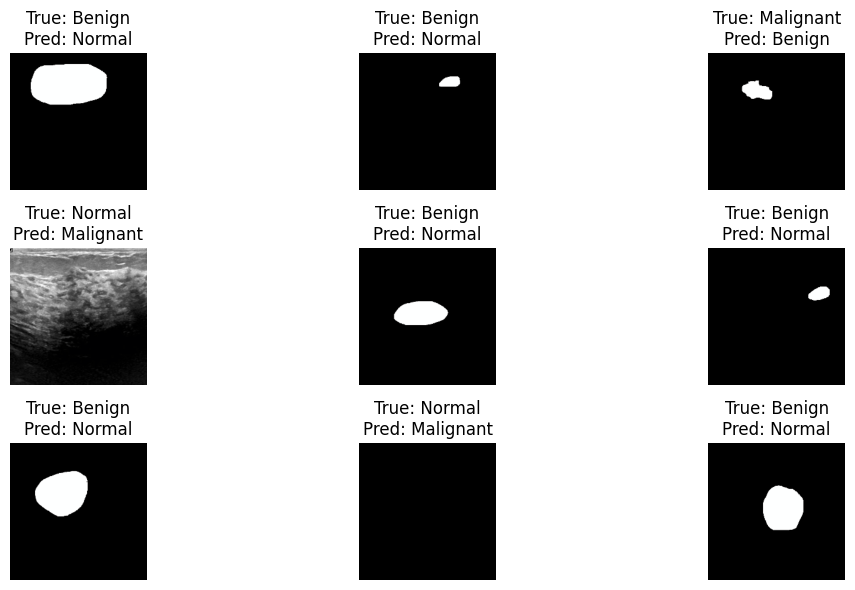

In [32]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# ------------------------
# 1️⃣ Visualization Function
# ------------------------
def visualize_classification(images, labels_true, labels_pred, class_names):
    """
    images: list of tumor patches (224x224x3 or tensors)
    labels_true: true class indices
    labels_pred: predicted class indices
    class_names: list of class names, e.g., ['Normal','Benign','Malignant']
    """
    plt.figure(figsize=(12,6))
    
    for i in range(min(9, len(images))):
        plt.subplot(3,3,i+1)
        img = images[i]
        
        # Convert tensor to numpy if needed
        if torch.is_tensor(img):
            img = img.permute(1,2,0).cpu().numpy()  # C,H,W -> H,W,C
            img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])  # unnormalize
            img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.title(f"True: {class_names[labels_true[i]]}\nPred: {class_names[labels_pred[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# ------------------------
# 2️⃣ Prepare validation labels
# ------------------------
val_labels = []
for path in val_paths:  # val_paths from your DataLoader split
    if "benign" in path.lower():
        val_labels.append(1)
    elif "malignant" in path.lower():
        val_labels.append(2)
    else:  # normal
        val_labels.append(0)

# ------------------------
# 3️⃣ Run model on validation set
# ------------------------
# Ensure model is defined and on correct device
resnet = model.to(device)
resnet.eval()

labels_pred = []
with torch.no_grad():
    for imgs, _ in val_loader:
        imgs = imgs.to(device)
        outputs = resnet(imgs)
        preds = torch.argmax(outputs, dim=1)
        labels_pred.extend(preds.cpu().numpy())

# ------------------------
# 4️⃣ Extract images from dataset (unnormalized for plotting)
# ------------------------
val_imgs_for_plot = []
for img, _ in val_loader.dataset:
    val_imgs_for_plot.append(img)

# ------------------------
# 5️⃣ Visualize predictions
# ------------------------
class_names = ['Normal','Benign','Malignant']
visualize_classification(val_imgs_for_plot, val_labels, labels_pred, class_names)


# A single model to do both segmentation and classification simultaneously, that’s called a ** multi-task learning setup **
## Multi-task Model Concept

## Shared Encoder: Extracts features from the input image.

## Segmentation Head: Outputs a pixel-wise mask (e.g., U-Net decoder).

## Classification Head: Outputs a class label (e.g., via global pooling + fully connected layer).

### Benefits

Jointly learns features useful for both segmentation and classification.

May improve performance on small datasets.

Avoids cropping & separate pipelines.

### Challenges

Harder to train — balancing the two losses can be tricky.

Requires images with both segmentation masks and class labels.

Decoder size may need tuning depending on input resolution.

## Step 1: Prepare Multi-Task Dataset

Since each image has a corresponding mask and a class label, we need a Dataset class that returns:

Input image (grayscale → RGB for ResNet encoder).

Segmentation mask (binary mask).

Class label (Normal=0, Benign=1, Malignant=2).

In [36]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# ------------------------
# Multi-task Dataset
# ------------------------
class BUSIMultiTaskDataset(Dataset):
    def __init__(self, img_paths, mask_paths, labels, transform=None):
        """
        img_paths: list of image file paths
        mask_paths: list of corresponding mask file paths
        labels: list of class labels (0=Normal,1=Benign,2=Malignant)
        transform: optional transform for input images
        """
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load image
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img, (256,256))

        # Load mask
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256,256))
        mask = mask / 255.0  # normalize 0-1
        mask = mask.astype('float32')
        mask = torch.tensor(mask).unsqueeze(0)  # [1,H,W]

        # Class label
        label = self.labels[idx]

        # Apply image transform if any
        if self.transform:
            img = self.transform(img)

        return img, mask, label

# ------------------------
# Define transforms for ResNet
# ------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


### Let’s collect all image paths, mask paths, and labels from your dataset folders so we can feed them into our BUSIMultiTaskDataset

In [37]:
# ------------------------
# Dataset paths
# ------------------------
base_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"
classes = ["benign", "malignant", "normal"]  # class folders

img_paths = []
mask_paths = []
labels = []

for i, cls in enumerate(classes):
    cls_folder = os.path.join(base_path, cls)
    for f in os.listdir(cls_folder):
        if f.endswith(".png") or f.endswith(".jpg"):
            img_paths.append(os.path.join(cls_folder, f))
            
            # corresponding mask
            # assuming masks are in the same folder with '_mask' in filename or separate folder
            mask_file = f.replace(".png","_mask.png").replace(".jpg","_mask.png")
            mask_path = os.path.join(base_path, f"{f[:-4]}_mask.png")
            
            # if mask exists
            if os.path.exists(mask_path):
                mask_paths.append(mask_path)
            else:
                # fallback: create dummy mask if missing
                mask_paths.append(os.path.join(base_path, cls, f))
            
            labels.append(i)  # 0=benign,1=malignant,2=normal

print(f"✅ Total images: {len(img_paths)}, Masks: {len(mask_paths)}, Labels: {len(labels)}")


✅ Total images: 1578, Masks: 1578, Labels: 1578


## Train/Validation Split + DataLoaders

In [39]:
from sklearn.model_selection import train_test_split

# ------------------------
# Train/Validation Split
# ------------------------
train_imgs, val_imgs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    img_paths, mask_paths, labels,
    test_size=0.2, random_state=42, stratify=labels
)

print(f" Train samples: {len(train_imgs)}, Validation samples: {len(val_imgs)}")

# ------------------------
# Create Datasets
# ------------------------
train_dataset = BUSIMultiTaskDataset(train_imgs, train_masks, train_labels, transform=transform)
val_dataset   = BUSIMultiTaskDataset(val_imgs, val_masks, val_labels, transform=transform)

# ------------------------
# Create DataLoaders
# ------------------------
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

print(" DataLoaders ready")


✅ Train samples: 1262, Validation samples: 316
 DataLoaders ready


## We'll use ResNet50 as the encoder and add:

Segmentation decoder → outputs a pixel-wise mask

Classification head → outputs 3-class labe

## Define Multi-Task Model

In [40]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiTaskUNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        
        # ------------------------
        # Encoder: Pretrained ResNet50
        # ------------------------
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.encoder = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
        )
        
        # ------------------------
        # Segmentation decoder
        # ------------------------
        self.seg_decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1),   # binary mask
            nn.Sigmoid()
        )
        
        # ------------------------
        # Classification head
        # ------------------------
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, x):
        features = self.encoder(x)
        mask = self.seg_decoder(features)
        class_logits = self.classifier(features)
        return mask, class_logits

# ------------------------
# Initialize model
# ------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MultiTaskUNet(num_classes=3).to(device)
print(f"✅ Multi-task model ready on {device}")


✅ Multi-task model ready on cuda


## Loss Functions and Optimizer

In [41]:
import torch.optim as optim

# ------------------------
# Losses
# ------------------------
seg_criterion = nn.BCELoss()           # for segmentation mask
cls_criterion = nn.CrossEntropyLoss()  # for classification

# ------------------------
# Optimizer
# ------------------------
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ------------------------
# Training settings
# ------------------------
num_epochs = 10
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []


## Multi-Task Training Loop

In [43]:
from tqdm import tqdm
import torch.nn.functional as F

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, masks, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        mask_pred, class_logits = model(imgs)
        
        # ------------------------
        # Upsample mask_pred to match ground truth
        # ------------------------
        mask_pred = F.interpolate(mask_pred, size=(256,256), mode='bilinear', align_corners=False)
        
        # Compute losses
        loss_seg = seg_criterion(mask_pred, masks)
        loss_cls = cls_criterion(class_logits, labels)
        
        # Total loss = weighted sum
        loss = loss_seg + loss_cls
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        _, predicted = torch.max(class_logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Epoch metrics
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    # ------------------------
    # Validation
    # ------------------------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for imgs, masks, labels in val_loader:
            imgs, masks, labels = imgs.to(device), masks.to(device), labels.to(device)
            mask_pred, class_logits = model(imgs)
            
            # Upsample validation mask_pred
            mask_pred = F.interpolate(mask_pred, size=(256,256), mode='bilinear', align_corners=False)
            
            loss_seg = seg_criterion(mask_pred, masks)
            loss_cls = cls_criterion(class_logits, labels)
            loss_val = loss_seg + loss_cls

            val_loss += loss_val.item() * imgs.size(0)
            _, predicted = torch.max(class_logits, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)

    print(f"Epoch {epoch+1}: Train Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f} | Val Loss={val_epoch_loss:.4f}, Acc={val_epoch_acc:.4f}")

    # Save best model
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model.state_dict(), "best_multitask_model.pth")
        print("✅ Saved best multi-task model")


Epoch 1/10: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


Epoch 1: Train Loss=1.1659, Acc=0.7124 | Val Loss=0.8182, Acc=0.8196
✅ Saved best multi-task model


Epoch 2/10: 100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 2: Train Loss=0.6489, Acc=0.8835 | Val Loss=0.6974, Acc=0.8703
✅ Saved best multi-task model


Epoch 3/10: 100%|██████████| 79/79 [00:32<00:00,  2.40it/s]


Epoch 3: Train Loss=0.4915, Acc=0.9501 | Val Loss=0.5975, Acc=0.9051
✅ Saved best multi-task model


Epoch 4/10: 100%|██████████| 79/79 [00:33<00:00,  2.39it/s]


Epoch 4: Train Loss=0.4289, Acc=0.9667 | Val Loss=0.5114, Acc=0.9335
✅ Saved best multi-task model


Epoch 5/10: 100%|██████████| 79/79 [00:33<00:00,  2.37it/s]


Epoch 5: Train Loss=0.4020, Acc=0.9739 | Val Loss=0.5620, Acc=0.9146


Epoch 6/10: 100%|██████████| 79/79 [00:32<00:00,  2.42it/s]


Epoch 6: Train Loss=0.3758, Acc=0.9802 | Val Loss=0.5831, Acc=0.9177


Epoch 7/10: 100%|██████████| 79/79 [00:32<00:00,  2.42it/s]


Epoch 7: Train Loss=0.3484, Acc=0.9865 | Val Loss=0.5564, Acc=0.9146


Epoch 8/10: 100%|██████████| 79/79 [00:32<00:00,  2.43it/s]


Epoch 8: Train Loss=0.3189, Acc=0.9897 | Val Loss=0.5074, Acc=0.9177


Epoch 9/10: 100%|██████████| 79/79 [00:32<00:00,  2.42it/s]


Epoch 9: Train Loss=0.3225, Acc=0.9881 | Val Loss=0.6288, Acc=0.9082


Epoch 10/10: 100%|██████████| 79/79 [00:32<00:00,  2.44it/s]


Epoch 10: Train Loss=0.3856, Acc=0.9707 | Val Loss=0.5893, Acc=0.9177


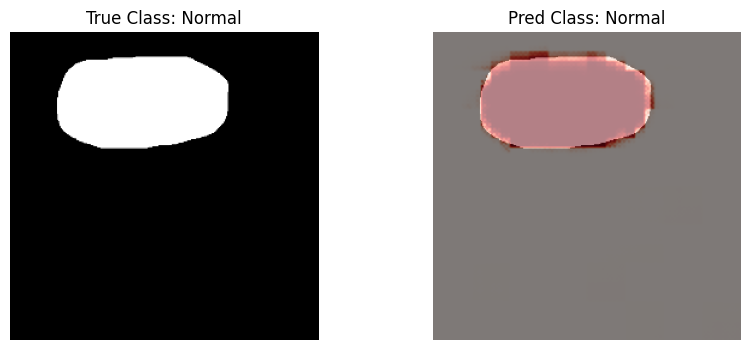

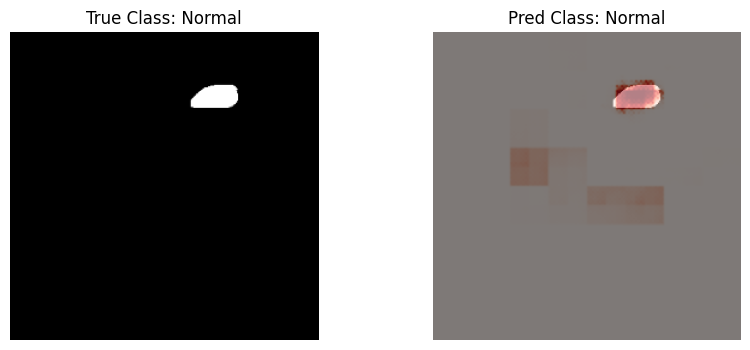

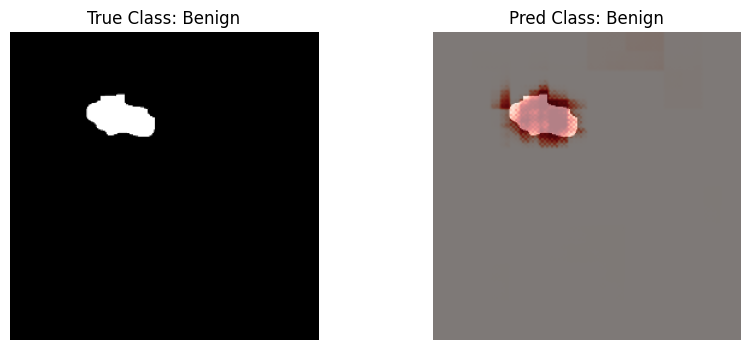

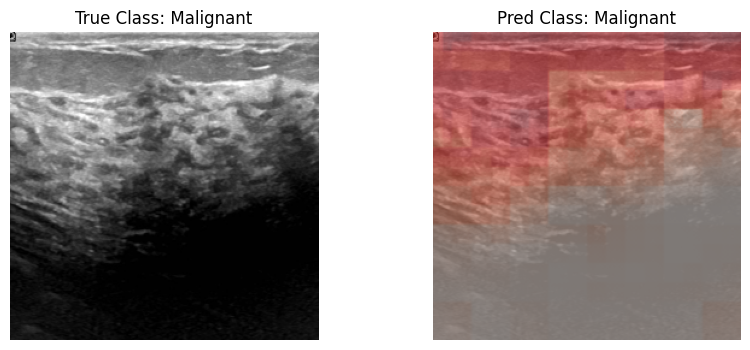

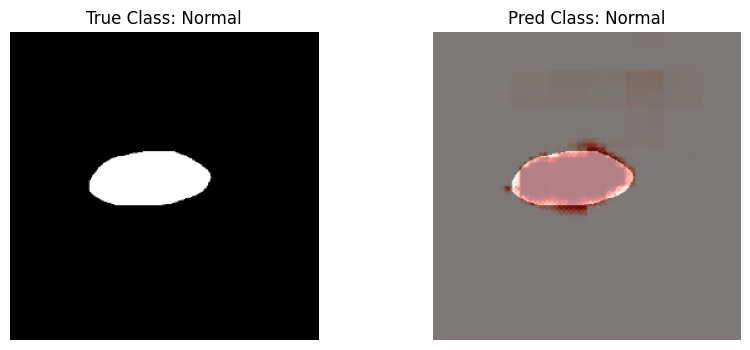

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

# ------------------------
# 1️⃣ Visualization Function
# ------------------------
def visualize_multitask(img_path, mask_pred, label_true, label_pred, class_names):
    """
    img_path: path to original image
    mask_pred: predicted mask (tensor or numpy, 256x256)
    label_true: ground truth class index
    label_pred: predicted class index
    class_names: ['Normal','Benign','Malignant']
    """
    # Load original image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256))
    
    # Convert mask_pred to numpy if tensor
    if torch.is_tensor(mask_pred):
        mask_pred = mask_pred.squeeze().cpu().numpy()
    
    plt.figure(figsize=(10,4))
    
    # Original image
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True Class: {class_names[label_true]}")
    plt.axis('off')
    
    # Image + predicted mask overlay
    plt.subplot(1,2,2)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask_pred, cmap='Reds', alpha=0.5)
    plt.title(f"Pred Class: {class_names[label_pred]}")
    plt.axis('off')
    
    plt.show()

# ------------------------
# 2️⃣ Run model on validation set and visualize first N examples
# ------------------------
class_names = ['Normal','Benign','Malignant']
num_examples = 5

model.eval()
with torch.no_grad():
    for i, (imgs, masks, labels) in enumerate(val_loader):
        imgs = imgs.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        
        mask_pred, class_logits = model(imgs)
        # Upsample mask_pred
        mask_pred = torch.nn.functional.interpolate(mask_pred, size=(256,256), mode='bilinear', align_corners=False)
        
        preds = torch.argmax(class_logits, dim=1)
        
        for j in range(imgs.size(0)):
            if i*val_loader.batch_size + j >= num_examples:
                break
            img_path = val_paths[i*val_loader.batch_size + j]  # original image path
            visualize_multitask(img_path, mask_pred[j], labels[j].item(), preds[j].item(), class_names)
        
        if i*val_loader.batch_size >= num_examples:
            break
